## Imports

In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image, ImageFile
import pandas as pd
import numpy as np

import tez
from tez.datasets import ImageDataset
from tez.callbacks import EarlyStopping

import torch
import torch.nn as nn

import torchvision

from sklearn import metrics, model_selection
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from tqdm.auto import tqdm

import csv


%matplotlib inline

## Config

In [2]:
VERSION = 'v4'
MODEL_PATH = './Model/model' + VERSION + '.bin'
TEST_PREDICTION_FILE = './TargetData-Test-Prediction-' + VERSION + '.csv'
CLASS_ACCURACY_FILE = './TargetData-Test-Accuracy-' + VERSION + '.csv'

IMAGE_SIZE = (400, 400)
TRAIN_BATCH_SIZE  = 32
VALID_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 6e-5

TRAINING_DATA_PATH = './TargetData-Train.csv'
VALIDATION_DATA_PATH = './TargetData-Valid.csv'
TEST_DATA_PATH = './TargetData-Test.csv'

IMAGE_FOLDER_PATH = './TargetImages/'

device = torch.device("cuda")
torch.cuda.empty_cache()
print(f'Device: {device}')

Device: cuda


## Dataset

In [3]:
class GLRDataset:
    def __init__(self, image_paths, targets, augmentations=None):
        self.image_paths = image_paths
        self.targets = targets
        self.augmentations = augmentations
        
    def __len__(self):
        return len(self.image_paths)    
    
    def __getitem__(self, item):
        targets = self.targets[item]
        image = Image.open(self.image_paths[item])
        augmented_image = self.augmentations(image)
        image_tensor = torch.tensor(np.transpose(np.array(augmented_image), (2, 0, 1)).astype(np.float32))
        
        return {
            'image': image_tensor,
            'targets': torch.tensor(targets),
        }

In [4]:
# Training Data
df_train = pd.read_csv(TRAINING_DATA_PATH)
train_image_paths = [
    os.path.join(IMAGE_FOLDER_PATH, x + '.jpg') for x in df_train.id.values
]
train_targets = df_train.label.values
train_aug = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomResizedCrop(size=(IMAGE_SIZE[0], IMAGE_SIZE[1]))
    ]
)
train_dataset = GLRDataset(
    image_paths = train_image_paths,
    targets = train_targets,
    augmentations = train_aug
)
train_data_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True
)
print(f'Total Batches in Train: {len(train_data_loader)}')
###############################################################

# Validation Data
df_valid = pd.read_csv(VALIDATION_DATA_PATH)
valid_image_paths = [
    os.path.join(IMAGE_FOLDER_PATH, x + '.jpg') for x in df_valid.id.values
]
valid_targets = df_valid.label.values
valid_aug = torchvision.transforms.Compose(
    [
        torchvision.transforms.CenterCrop(size=(IMAGE_SIZE[0], IMAGE_SIZE[1])),
        torchvision.transforms.Resize(size=(IMAGE_SIZE[0], IMAGE_SIZE[1]))
    ]
)
valid_dataset = GLRDataset(
    image_paths = valid_image_paths,
    targets = valid_targets,
    augmentations = valid_aug
)
valid_data_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=VALID_BATCH_SIZE,
    shuffle=False
)

print(f'Total Batches in Validation: {len(valid_data_loader)}')
###############################################################


# Test Data
df_test = pd.read_csv(TEST_DATA_PATH)
test_image_paths = [
    os.path.join(IMAGE_FOLDER_PATH, x + '.jpg') for x in df_test.id.values
]
test_targets = df_test.label.values
test_aug = torchvision.transforms.Compose(
    [
        torchvision.transforms.CenterCrop(size=(IMAGE_SIZE[0], IMAGE_SIZE[1])),
        torchvision.transforms.Resize(size=(IMAGE_SIZE[0], IMAGE_SIZE[1]))
    ]
)
test_dataset = GLRDataset(
    image_paths = test_image_paths,
    targets = test_targets,
    augmentations = test_aug
)

test_data_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False
)

print(f'Total Batches in Test: {len(test_data_loader)}')
###############################################################

Total Batches in Train: 1154
Total Batches in Validation: 129
Total Batches in Test: 143


## Plot Images

In [5]:
def plot_img(image_dict):
    image_tensor = image_dict['image']
    target = image_dict['targets']
    print(f'Target: {target}')
    plt.figure(figsize=(10, 10))
    image = image_tensor.permute(1, 2, 0) / 255
    plt.imshow(image)

Target: 32


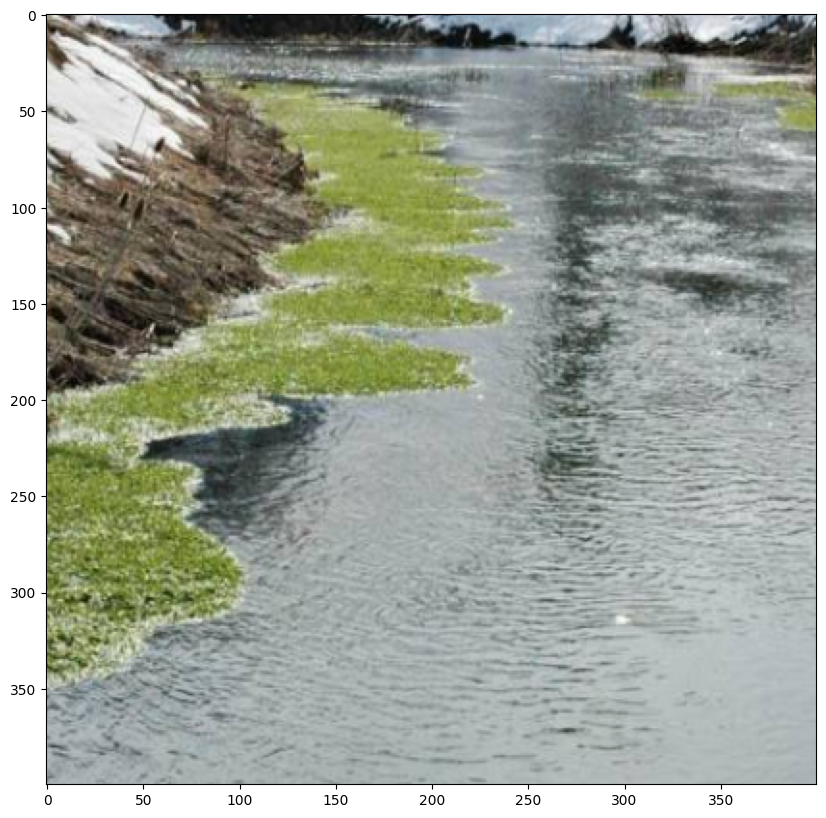

In [6]:
plot_img(train_dataset[10])

## Model

In [7]:
class GLRModel(tez.Model):
    def __init__(self, num_classes):
        super().__init__()
        self.convnet = torchvision.models.googlenet(pretrained=True)
        self.convnet.fc = nn.Linear(1024, num_classes)   
    
    def forward(self, image):
        outputs = self.convnet(image)        
        return outputs

## Loss Function & Metric

In [8]:
def loss_function(outputs, targets):
    return nn.CrossEntropyLoss()(outputs, targets)
    
def count_correct(outputs, targets):
    outputs = torch.argmax(outputs, dim=1).cpu().detach().numpy()
    targets = targets.cpu().detach().numpy()
    total_correct = np.sum(outputs == targets)
    
    return total_correct

## Training

In [9]:
NUM_CLASSES = df_train.label.nunique()
model = GLRModel(num_classes = NUM_CLASSES)
model.to(device)

param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
    {
        "params": [
            p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.005,
    },
    {
        "params": [
            p for n, p in param_optimizer if any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.0,
    },
]

num_train_steps = int(len(train_data_loader) * EPOCHS)
optimizer = torch.optim.AdamW(optimizer_parameters, lr=LEARNING_RATE)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=500,
    num_training_steps=num_train_steps
)

best_loss = float('inf')
print(f'Model Training Started')

for epoch in range(EPOCHS):
        
    total_train_loss = 0.0
    total_train_correct = 0
    for batch_index, data in tqdm(enumerate(train_data_loader), total=len(train_data_loader)):        
        
        image = data['image']
        targets = data['targets']
        
        image = image.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(image=image)        
        
        loss = loss_function(outputs, targets)
        
        with torch.no_grad():
            total_train_loss += loss.item()
            total_train_correct += count_correct(outputs, targets)
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        
    total_valid_loss = 0.0
    total_valid_correct = 0
    with torch.no_grad():
        model.eval()
        for batch_index, data in tqdm(enumerate(valid_data_loader), total=len(valid_data_loader)):
            image = data['image']
            targets = data['targets']
        
            image = image.to(device)
            targets = targets.to(device)
        
            outputs = model(image=image)
            
            validloss = loss_function(outputs, targets)
            total_valid_loss += validloss.item()            
            total_valid_correct += count_correct(outputs, targets)
            
        total_valid_loss = total_valid_loss / len(valid_data_loader)
        total_train_loss = total_train_loss / len(train_data_loader)
        print(f'Epoch: {epoch + 1} :: Training Loss: {total_train_loss:.4f}, Validation Loss: {total_valid_loss:.4f}')
        print(f'Training Accuracy: {total_train_correct / len(train_dataset) * 100:.2f}, Validation Accuracy: {total_valid_correct / len(valid_dataset) * 100:.2f}')
        
        if total_valid_loss < best_loss:
            torch.save(model.state_dict(), MODEL_PATH)
            best_loss = total_valid_loss

Model Training Started


  0%|          | 0/1154 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 1 :: Training Loss: 2.3307, Validation Loss: 1.0324
Training Accuracy: 44.66, Validation Accuracy: 74.29


  0%|          | 0/1154 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 2 :: Training Loss: 0.8323, Validation Loss: 0.6340
Training Accuracy: 76.10, Validation Accuracy: 81.43


  0%|          | 0/1154 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 3 :: Training Loss: 0.5707, Validation Loss: 0.5217
Training Accuracy: 83.40, Validation Accuracy: 83.84


  0%|          | 0/1154 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 4 :: Training Loss: 0.4667, Validation Loss: 0.4784
Training Accuracy: 86.12, Validation Accuracy: 85.16


  0%|          | 0/1154 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 5 :: Training Loss: 0.4014, Validation Loss: 0.3745
Training Accuracy: 88.06, Validation Accuracy: 88.67


  0%|          | 0/1154 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 6 :: Training Loss: 0.3502, Validation Loss: 0.3221
Training Accuracy: 89.61, Validation Accuracy: 90.81


  0%|          | 0/1154 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 7 :: Training Loss: 0.3192, Validation Loss: 0.3280
Training Accuracy: 90.44, Validation Accuracy: 90.74


  0%|          | 0/1154 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 8 :: Training Loss: 0.2919, Validation Loss: 0.3038
Training Accuracy: 91.30, Validation Accuracy: 90.98


  0%|          | 0/1154 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 9 :: Training Loss: 0.2661, Validation Loss: 0.3004
Training Accuracy: 92.04, Validation Accuracy: 90.74


  0%|          | 0/1154 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 10 :: Training Loss: 0.2434, Validation Loss: 0.3365
Training Accuracy: 92.60, Validation Accuracy: 90.18


  0%|          | 0/1154 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 11 :: Training Loss: 0.2225, Validation Loss: 0.3038
Training Accuracy: 93.29, Validation Accuracy: 91.01


  0%|          | 0/1154 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 12 :: Training Loss: 0.2097, Validation Loss: 0.3130
Training Accuracy: 93.55, Validation Accuracy: 91.96


  0%|          | 0/1154 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 13 :: Training Loss: 0.1884, Validation Loss: 0.2708
Training Accuracy: 94.25, Validation Accuracy: 92.44


  0%|          | 0/1154 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 14 :: Training Loss: 0.1766, Validation Loss: 0.2323
Training Accuracy: 94.68, Validation Accuracy: 93.37


  0%|          | 0/1154 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 15 :: Training Loss: 0.1599, Validation Loss: 0.2884
Training Accuracy: 95.24, Validation Accuracy: 92.44


  0%|          | 0/1154 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 16 :: Training Loss: 0.1488, Validation Loss: 0.2534
Training Accuracy: 95.60, Validation Accuracy: 93.47


  0%|          | 0/1154 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 17 :: Training Loss: 0.1467, Validation Loss: 0.2028
Training Accuracy: 95.69, Validation Accuracy: 94.49


  0%|          | 0/1154 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 18 :: Training Loss: 0.1344, Validation Loss: 0.2048
Training Accuracy: 96.14, Validation Accuracy: 94.52


  0%|          | 0/1154 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 19 :: Training Loss: 0.1277, Validation Loss: 0.2092
Training Accuracy: 96.18, Validation Accuracy: 94.17


  0%|          | 0/1154 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 20 :: Training Loss: 0.1203, Validation Loss: 0.1944
Training Accuracy: 96.43, Validation Accuracy: 94.81


In [10]:
NUM_CLASSES = df_train.label.nunique()
loaded_model = GLRModel(num_classes = NUM_CLASSES)
loaded_model.to(device)
loaded_model.load_state_dict(torch.load(MODEL_PATH))
loaded_model.eval()

total_test_correct = 0
index = 0
df_test['prediction'] = 'Missing Prediction'
with torch.no_grad():
        for batch_index, data in tqdm(enumerate(test_data_loader), total=len(test_data_loader)):
            image = data['image']
            targets = data['targets']
        
            image = image.to(device)
            targets = targets.to(device)
        
            outputs = model(image=image)
            total_test_correct += count_correct(outputs, targets)
            outputs = torch.argmax(outputs, dim=1).cpu().detach().numpy()
            for i in range(len(targets)):                            
                df_test['prediction'][index] = outputs[i]
                index += 1             

                
print(f'Test Accuracy: {total_test_correct / len(test_dataset) * 100:.2f}')       
df_test.to_csv(TEST_PREDICTION_FILE, sep=',')

  0%|          | 0/143 [00:00<?, ?it/s]

C:\Users\vibhatna\AppData\Local\Temp\ipykernel_15496\3020032175.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['prediction'][index] = outputs[i]


Test Accuracy: 94.65


In [11]:
df_prediction = pd.read_csv(TEST_PREDICTION_FILE)
class_correct_count = {}
class_total_count = {}
index = 0
for label in df_prediction.label.values:
    if label not in class_total_count:
        class_total_count[label] = 0
        class_correct_count[label] = 0
        
    if label == df_prediction.prediction[index]:
        class_correct_count[label] += 1
    
    class_total_count[label] += 1
    index+=1


In [12]:
accuracy_sum = 0.0

with open(CLASS_ACCURACY_FILE, "w", newline='') as filec:
    writerc = csv.writer(filec, delimiter=',')
    writerc.writerow(('class_id','total_count', 'total_correct', 'accuracy'))
    
    for class_id, total_count in class_total_count.items():
        total_correct = class_correct_count[class_id]
        accuracy = total_correct / total_count * 100.0
        accuracy_sum += accuracy
        writerc.writerow((class_id, total_count, total_correct, round(accuracy, 2)))
        
        
print(f'Balanced Accuracy: {accuracy_sum / NUM_CLASSES :.2f}')

Balanced Accuracy: 94.22


Target: 29


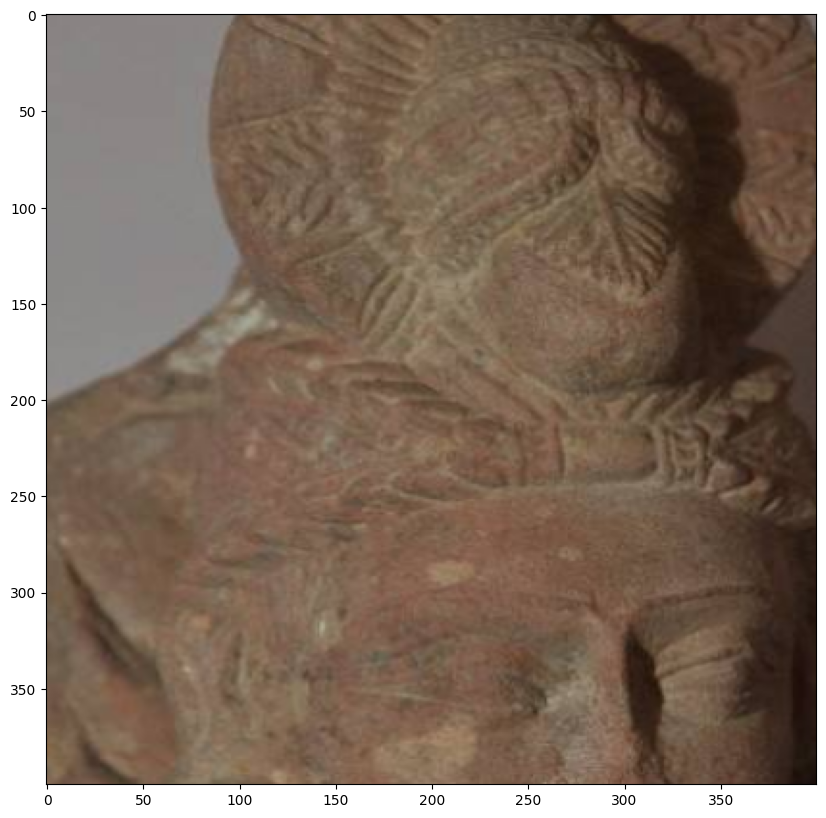

In [13]:
target_class = 29
target_class_index = 8
count = 0 
for index in range(len(train_dataset)):
    if train_dataset[index]['targets'] == target_class:
        count += 1        
        if count == target_class_index:        
            plot_img(train_dataset[index])
            break